# Task 2 — Simple Sales Forecast with Moving Average

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import shutil

In [ ]:
df = pd.read_csv("train.csv", parse_dates=['date'])
print("Rows:", len(df), "Columns:", df.columns.tolist())

Rows: 3000888 Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


In [ ]:
daily = df.groupby('date', as_index=False)['sales'].sum().sort_values('date')
daily = daily.rename(columns={'sales': 'total_sales'})
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.set_index('date').asfreq('D')
daily['total_sales'] = daily['total_sales'].fillna(0)

In [ ]:
daily['ma_7'] = daily['total_sales'].rolling(window=7, min_periods=1).mean()
daily['ma_30'] = daily['total_sales'].rolling(window=30, min_periods=1).mean()

In [ ]:
holdout_days = 30
if len(daily) <= holdout_days + 30:
    holdout_days = max(1, int(len(daily) * 0.2))
print("Using holdout_days =", holdout_days)

train = daily.iloc[:-holdout_days].copy()
test = daily.iloc[-holdout_days:].copy()

Using holdout_days = 30


In [ ]:
last_7_train = train['total_sales'].rolling(window=7, min_periods=1).mean().iloc[-1]
last_30_train = train['total_sales'].rolling(window=30, min_periods=1).mean().iloc[-1]
forecast_static_7 = np.full(shape=len(test), fill_value=last_7_train)
forecast_static_30 = np.full(shape=len(test), fill_value=last_30_train)

In [ ]:
def sequential_ma_forecast(series_values, window, holdout_days):
    n = len(series_values)
    forecasts = []
    start_index = n - holdout_days
    for i in range(start_index, n):
        begin = max(0, i - window)
        if i == begin:
            val = series_values[:i].mean() if i > 0 else 0.0
        else:
            val = series_values[begin:i].mean()
        forecasts.append(val)
    return np.array(forecasts)

In [ ]:
full_actuals = pd.concat([train['total_sales'], test['total_sales']]).values
seq_forecast_7 = sequential_ma_forecast(full_actuals, window=7, holdout_days=holdout_days)
seq_forecast_30 = sequential_ma_forecast(full_actuals, window=30, holdout_days=holdout_days)

In [ ]:
test = test.copy()
test['forecast_static_7'] = forecast_static_7
test['forecast_static_30'] = forecast_static_30
test['forecast_seq_7'] = seq_forecast_7
test['forecast_seq_30'] = seq_forecast_30

In [ ]:
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

metrics = {
    'static_7': compute_metrics(test['total_sales'], test['forecast_static_7']),
    'static_30': compute_metrics(test['total_sales'], test['forecast_static_30']),
    'seq_7': compute_metrics(test['total_sales'], test['forecast_seq_7']),
    'seq_30': compute_metrics(test['total_sales'], test['forecast_seq_30']),
}

metrics_df = pd.DataFrame([
    {'method': 'static_7', 'MAE': metrics['static_7'][0], 'RMSE': metrics['static_7'][1]},
    {'method': 'static_30', 'MAE': metrics['static_30'][0], 'RMSE': metrics['static_30'][1]},
    {'method': 'seq_7', 'MAE': metrics['seq_7'][0], 'RMSE': metrics['seq_7'][1]},
    {'method': 'seq_30', 'MAE': metrics['seq_30'][0], 'RMSE': metrics['seq_30'][1]},
])

print(metrics_df)

      method            MAE           RMSE
0   static_7   98150.794183  123357.453850
1  static_30  110424.760632  126494.272607
2      seq_7   97824.324435  122221.137515
3     seq_30  104430.367577  122169.443414


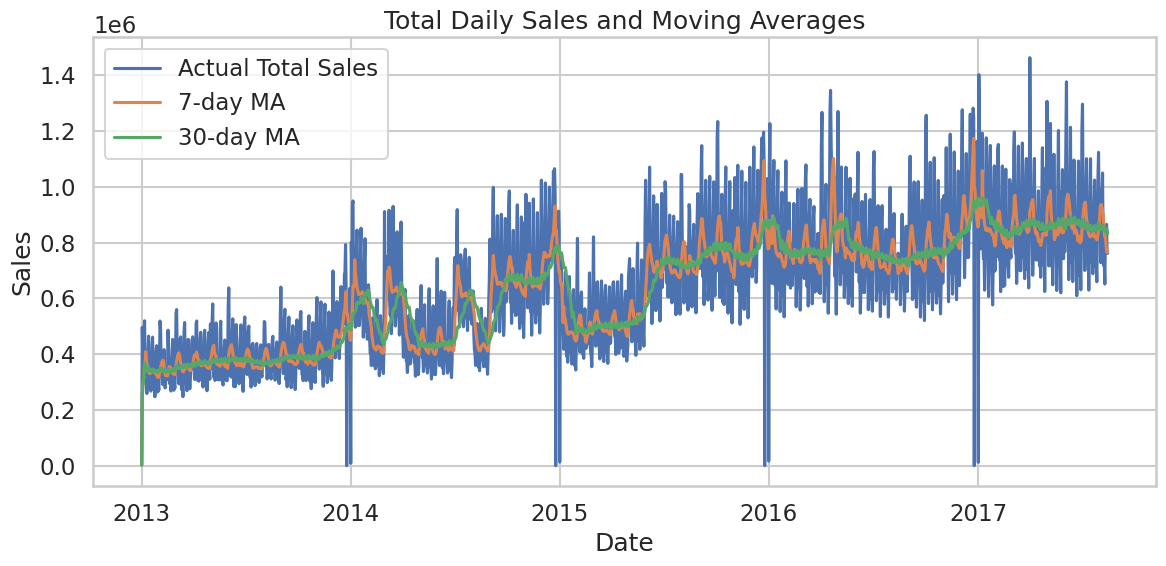

In [ ]:
# Full series with moving averages
plt.figure(figsize=(12,6))
plt.plot(daily.index, daily['total_sales'], label='Actual Total Sales')
plt.plot(daily.index, daily['ma_7'], label='7-day MA')
plt.plot(daily.index, daily['ma_30'], label='30-day MA')
plt.title('Total Daily Sales and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

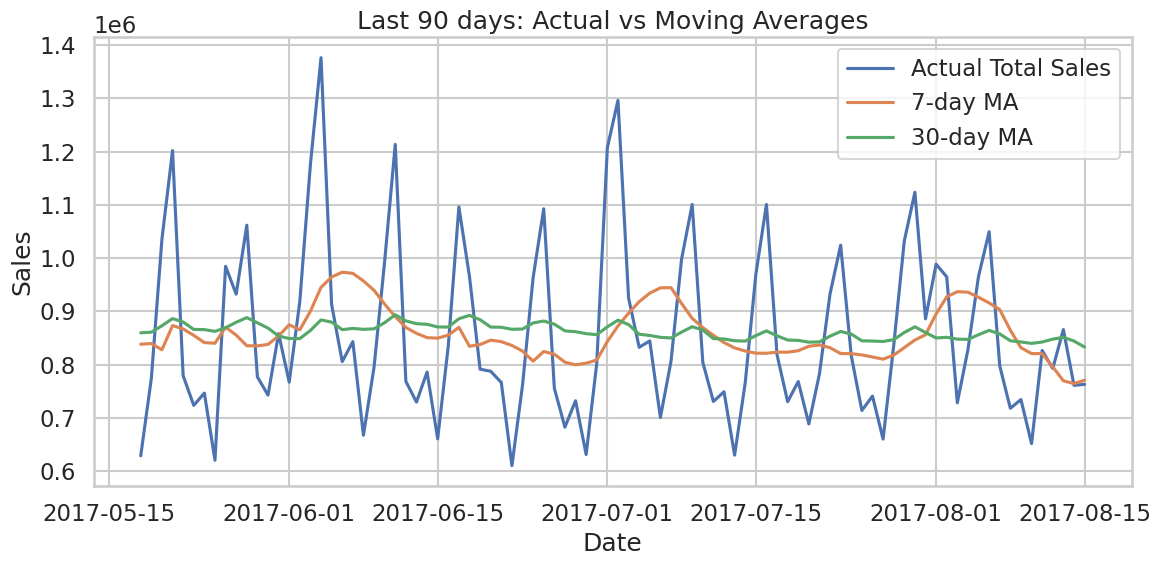

In [ ]:
# Last N days trend
zoom_days = 90
if len(daily) < zoom_days:
    zoom_days = len(daily)
last_period = daily.iloc[-zoom_days:]
plt.figure(figsize=(12,6))
plt.plot(last_period.index, last_period['total_sales'], label='Actual Total Sales')
plt.plot(last_period.index, last_period['ma_7'], label='7-day MA')
plt.plot(last_period.index, last_period['ma_30'], label='30-day MA')
plt.title(f'Last {zoom_days} days: Actual vs Moving Averages')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

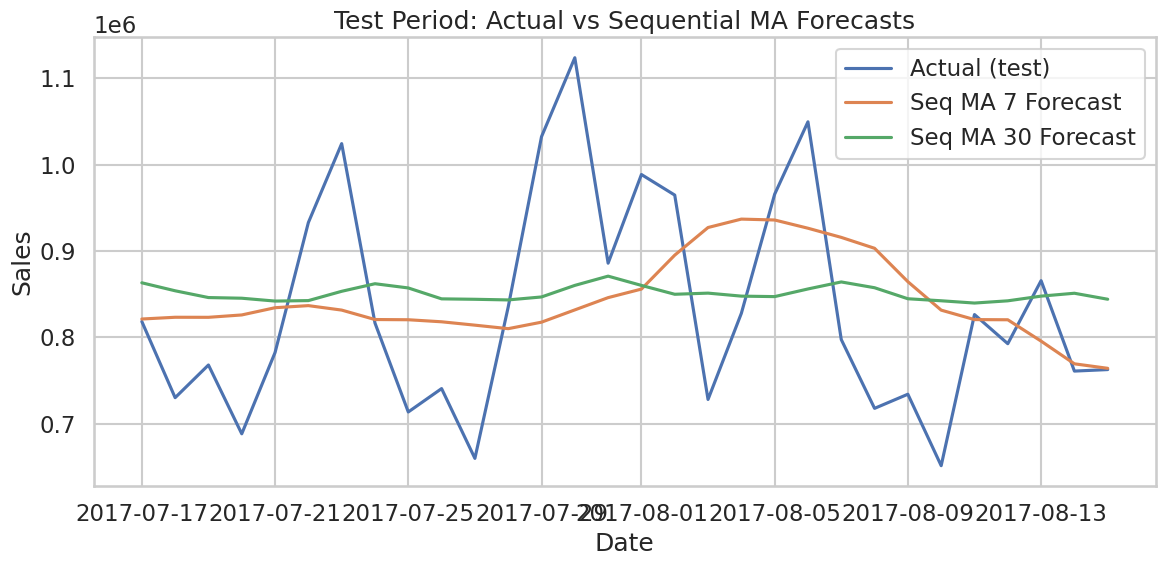

In [ ]:
# Test period actual vs sequential
plt.figure(figsize=(12,6))
plt.plot(test.index, test['total_sales'], label='Actual (test)')
plt.plot(test.index, test['forecast_seq_7'], label='Seq MA 7 Forecast')
plt.plot(test.index, test['forecast_seq_30'], label='Seq MA 30 Forecast')
plt.title('Test Period: Actual vs Sequential MA Forecasts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()